In [95]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from numpy import linalg as LA
from sklearn.preprocessing import MinMaxScaler

In [96]:
train1x5 = pd.read_csv('../dataset/train1x5.csv')
test1x5 = pd.read_csv('../dataset/test1x5.csv')

In [97]:
scaler = MinMaxScaler()

#ajusta e transforma
train1x5_scaled = scaler.fit_transform(train1x5.drop('label', axis=1)) 
#transforma para evitar vazamento
test1x5_scaled = scaler.transform(test1x5.drop('label', axis=1)) 

train1x5['i_normalizada'] = train1x5_scaled[:,0]
train1x5['s_normalizada'] = train1x5_scaled[:,1]

test1x5['i_normalizada'] = test1x5_scaled[:,0]
test1x5['s_normalizada'] = test1x5_scaled[:,1]

In [98]:
#para testes
y_train_orig = train1x5['label']
y_test_orig = test1x5['label']

#normalizando
x_train = np.hstack((np.ones((len(train1x5), 1)), train1x5[['i_normalizada', 's_normalizada']].values))
y_train = np.array([1 if y_ == 1 else -1 for y_ in train1x5['label']])

x_test = np.hstack((np.ones((len(test1x5), 1)), test1x5[['i_normalizada', 's_normalizada']].values))
y_test = np.array([1 if y_ == 1 else -1 for y_ in test1x5['label']])


#escalonando
x_train_orig = scaler.inverse_transform(train1x5[['i_normalizada', 's_normalizada']].values)
x_train_orig = np.hstack((np.ones((len(train1x5), 1)), x_train_orig))

x_test_orig = scaler.inverse_transform(test1x5[['i_normalizada', 's_normalizada']].values)
x_test_orig = np.hstack((np.ones((len(test1x5), 1)), x_test_orig))

In [99]:
y_train

array([ 1,  1,  1, ..., -1, -1, -1])

## Regressão Logistica:

### Equações:

$ W = \begin{bmatrix}w_1 \\ w_2 \\ . \\ . \\ w_n \end{bmatrix}_{ n x 1}$ .........inicializada com zeros

$ B = peso/parâmetro \: unico:\:Bias$ 

$ X = \begin{bmatrix}. & . & .  \\ .  & . & .  \\ . & . & .  \\ . & . & .  \\ \end{bmatrix}_{n x m}$

$ Y = \begin{bmatrix}. & . & . & . & . \end{bmatrix}_{1 x m}$

A = $\sigma ( W^T*X + b ) $    ........ (probabilidades preditas (1 x m ) )


### Função sigmoide:

$$
y(s) = \frac{1}{1 + e^{-y_s}} = \frac{e^{y_s}}{1+e^{y_s}}
$$

### Log-verossimilhança / Log Loss / Entropia Cruzada Binária (custo):

$$
J(θ) = -\frac{1}{m} \sum_{i=1}^{m} \left[ y^{(i)} \log(h_θ(x^{(i)})) + (1 - y^{(i)}) \log(1 - h_θ(x^{(i)})) \right]
$$

### Gradiente:

$$
∇J(θ) = \frac{1}{m} X^T \left(h_θ(X) - y\right)
$$

In [100]:
def acuracia(y, pred, conjunto):

    total = len(y)

    acertos = 0

    for i in range(total):
        if pred[i] == y[i]:
            acertos += 1
    
    print(f"Acuracia do modelo no conjunto {conjunto}: {(acertos/total)*100:.2f}%")

In [101]:
class RegressaoLogistica():

    def __init__(self, learning_rate = 0.1, iterations = 10000, bs = 12):
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.batch_size = bs

    def sigmoide(self, x):
        return 1/(1 + np.exp(-x))        

    def fit(self, X, Y):
        
        X = np.array(X)
        Y = np.array(Y)

        #numero de amostras
        m = X.shape[0]
        
        #numero de features
        n = X.shape[1]

        W = np.zeros(n, dtype = float)

        self.W = []
        
        
        for i in range(self.iterations):
            
            #vetor acumulador dos gradientes
            v_g = np.zeros(n, dtype = float)

            
            #caso o lote seja menor, escolher aleatoriamente uma nova mini-amostra
            if self.batch_size < m:

                indices = random.sample(range(m), self.batch_size)

                batch_x = [X[j] for j in indices]
                batch_y = [Y[j] for j in indices]

            else:
                batch_x = X
                batch_y = Y

            
            for x_, y_ in zip(batch_x, batch_y):
                
                #gradiente dos pesos atuais com sigmoide inversa
                v_g += (y_ * x_) / (1 + np.exp((y_ * W).T @ x_))

            #gradiente medio
            g_m = v_g / self.batch_size

            #condição de parada
            if LA.norm(g_m) < 0.0001:
                break

            #atualiza os pesos
            W += self.learning_rate * g_m

        self.W = W

    def predict(self, X):
        
        #probabilidade
        Z = np.dot(X, self.W)
        prob = np.exp(Z) / (1 + np.exp(Z))
                
        y_pred = np.where(prob >= 0.5, 1, -1)

        return y_pred
    
    def normaliza_y(self, x, shift = 0):
        return (-self.W[0] + shift - self.W[1] * x) / self.W[2]

In [102]:
rl = RegressaoLogistica()
rl.fit(x_train, y_train)
y_pred_treino = rl.predict(x_train)

In [103]:
y_pred_teste = rl.predict(x_test)

### Vizualização Gráfica

Linha de Decisão:
$$Z = W[0] \times X_1 + W[1] \times X_2 + B$$

Onde:
<br>
- $W[i] * X_i$ (pesos aplicado a feature) ajustam a inclinação da reta <br>
- $B$ (bias) ajusta a posição da reta no gráfico

In [104]:
import seaborn as sns

def plot(x_or, y_pred, data, modelo):

    xmin = x_or[:,1].min()
    xmax = x_or[:,1].max()

    sns.scatterplot(x='intensidade', y='simetria', hue=y_pred, data=data, palette='coolwarm', s=5)

    x = np.linspace(xmin, xmax, 100)

    x_normalized = scaler.transform(np.column_stack((x, np.zeros_like(x))))[:, 0]
    y_normalized = modelo.normaliza_y(x_normalized)

    y = scaler.inverse_transform(np.column_stack((x, y_normalized)))[:, 1]

    plt.plot(x, y, 'y-', label='g(.)')
    plt.legend(loc='upper right')
    plt.show()

Treino


C:\Users\kamil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


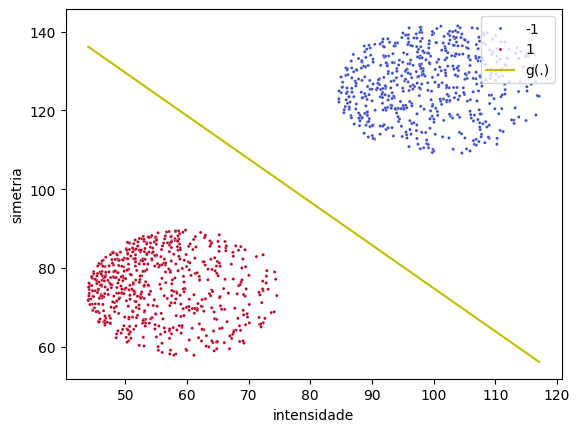


Teste


C:\Users\kamil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


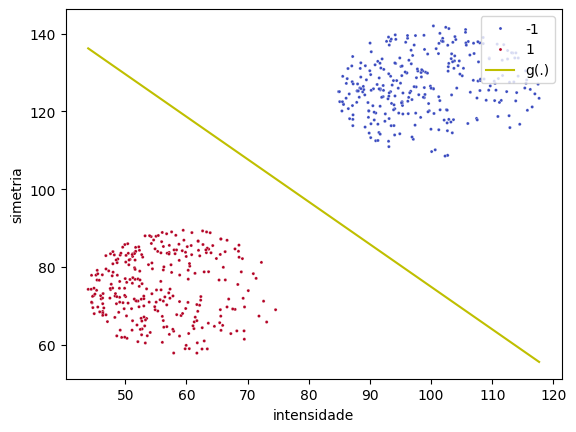

In [105]:
print('Treino')
plot(x_train_orig, y_pred_treino, train1x5, rl)

print('')
print('Teste')
plot(x_test_orig, y_pred_teste, test1x5, rl)

## Eficiência da Classificação

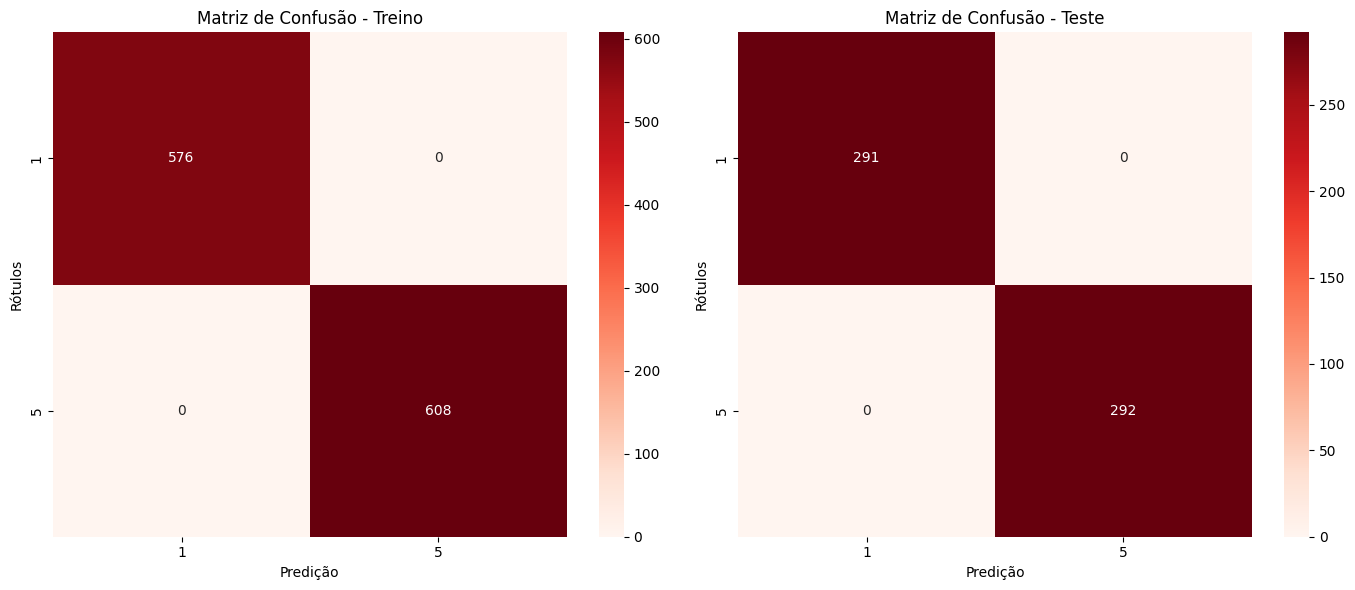

In [106]:
from sklearn.metrics import confusion_matrix

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

cm = confusion_matrix(y_train, y_pred_treino)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', 
            xticklabels=['1', '5'], 
            yticklabels=['1', '5'], ax=axes[0])
axes[0].set_xlabel('Predição')
axes[0].set_ylabel('Rótulos')
axes[0].set_title('Matriz de Confusão - Treino')

cm_test = confusion_matrix(y_test, y_pred_teste)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Reds', 
            xticklabels=['1', '5'], 
            yticklabels=['1', '5'], ax=axes[1])
axes[1].set_xlabel('Predição')
axes[1].set_ylabel('Rótulos')
axes[1].set_title('Matriz de Confusão - Teste')

plt.tight_layout()
plt.show()


Treino
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       576
           1       1.00      1.00      1.00       608

    accuracy                           1.00      1184
   macro avg       1.00      1.00      1.00      1184
weighted avg       1.00      1.00      1.00      1184



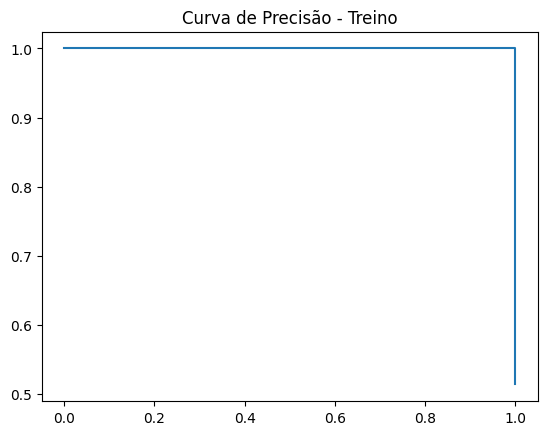


Teste
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       291
           1       1.00      1.00      1.00       292

    accuracy                           1.00       583
   macro avg       1.00      1.00      1.00       583
weighted avg       1.00      1.00      1.00       583



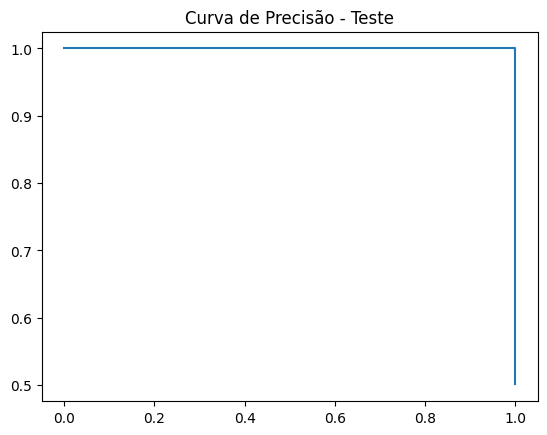

In [107]:
from sklearn.metrics import precision_recall_curve, classification_report

print('')
print('Treino')

report = classification_report(y_train, y_pred_treino)
#precisão x sensibilidade*
precision, recall, _ = precision_recall_curve(y_train, y_pred_treino)

print(report)

plt.plot(recall, precision)
plt.title('Curva de Precisão - Treino')
plt.show()


print('')
print('Teste')

report_test = classification_report(y_test, y_pred_teste)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_pred_teste)

print(report_test)

plt.plot(recall_test, precision_test)
plt.title('Curva de Precisão - Teste')
plt.show()


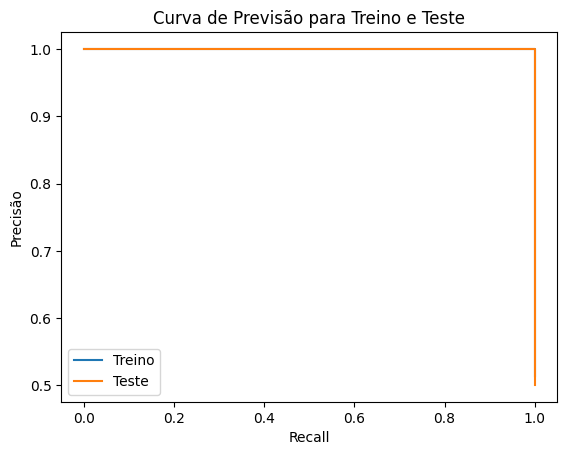

In [108]:
precision, recall, thresholds = precision_recall_curve(y_train, y_pred_treino)
plt.plot(recall, precision, label=f'Treino')

precision_, recall_, thresholds_ = precision_recall_curve(y_test, y_pred_teste)
plt.plot(recall_, precision_, label=f'Teste')


plt.xlabel('Recall')
plt.ylabel('Precisão')
plt.title('Curva de Previsão para Treino e Teste')
plt.legend()
plt.show()

In [109]:
acuracia(y_train, y_pred_treino, "teste")
acuracia(y_test, y_pred_teste, "treino")

Acuracia do modelo no conjunto teste: 100.00%
Acuracia do modelo no conjunto treino: 100.00%


In [110]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

print('Metricas de Erro - Treino')
print("Erro médio quadrático: ", mean_squared_error(y_train, y_pred_treino))
print("Erro médio absoluto: ", mean_absolute_error(y_train, y_pred_treino))

print('')
print('Metricas de Erro - Teste')
print("Erro médio quadrático: ", mean_squared_error(y_test, y_pred_teste))
print("Erro médio absoluto: ", mean_absolute_error(y_test, y_pred_teste))

Metricas de Erro - Treino
Erro médio quadrático:  0.0
Erro médio absoluto:  0.0

Metricas de Erro - Teste
Erro médio quadrático:  0.0
Erro médio absoluto:  0.0


## Métricas Gerais

In [111]:
#erro dentro da amostra (Ein)
N_in = len(y_train)
eIn = 0
for i in range(N_in):
    if(y_pred_treino[i] != y_train[i]):
        eIn += 1
eIn /= N_in
print("Ein = " + str(eIn))

#erro fora da amostra (Eout)
N_out = len(y_test)
eOut = 0
for i in range(N_out):
    if(y_pred_teste[i] != y_test[i]):
        eOut += 1
eOut /= N_out
print("Eout = " + str(eOut))

Ein = 0.0
Eout = 0.0


### Comparação com biblioteca pronta

Acuracia: 100.00%
Classificação:
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       291
           1       1.00      1.00      1.00       292

    accuracy                           1.00       583
   macro avg       1.00      1.00      1.00       583
weighted avg       1.00      1.00      1.00       583



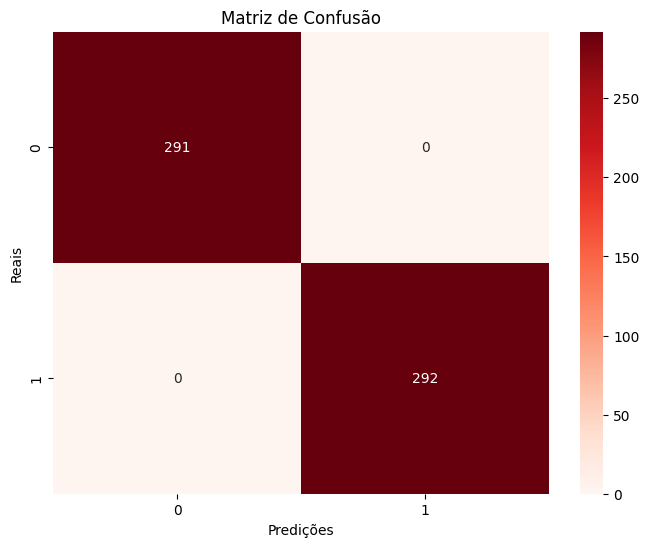

In [112]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

model = LogisticRegression()

model.fit(x_train, y_train)

y_pred = model.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred)

report = classification_report(y_test, y_pred)

print(f'Acuracia: {accuracy*100:.2f}%')
print('Classificação:')
print(report)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predições')
plt.ylabel('Reais')
plt.title('Matriz de Confusão')
plt.show()